# Model Laden
Laadt direct een model van Hugging Face voor nummerplaten lezen.

In [2]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import cv2
import torch
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO
import numpy as np
import random
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
# Use TrOCR model which is designed for OCR tasks
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-printed")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Combinatie van Modellen
Combineer je bestaande nummerplaat detectiemodel met het Hugging Face tekstherkenningsmodel

In [4]:
# Functie om je bestaande model te gebruiken voor nummerplaat detectie
def detect_license_plates(image_path):
    # Laad je eigen model
    detector = YOLO('../../models/trained/license_plate_detector6/weights/best.pt')
    
    # Voer detectie uit met het YOLO model
    results = detector(image_path)
    
    # Verwerk de resultaten naar het gewenste formaat
    detections = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            # Haal bounding box coördinaten op
            x1, y1, x2, y2 = box.xyxy[0].tolist()
            
            # Rond de coördinaten af naar gehele getallen
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            # Haal confidence score op
            confidence = float(box.conf[0])
            
            # Voeg de detectie toe aan de lijst
            detections.append({
                'bbox': [x1, y1, x2, y2],
                'confidence': confidence
            })
    
    return detections

In [5]:
# Functie om tekst te lezen van een uitgesneden nummerplaat met het Hugging Face-model
def read_license_plate(plate_image):
    # Converteer de afbeelding naar het juiste formaat voor het model
    if isinstance(plate_image, np.ndarray):  # Als het een cv2/numpy afbeelding is
        plate_image = Image.fromarray(cv2.cvtColor(plate_image, cv2.COLOR_BGR2RGB))
    
    # Gebruik de processor om de invoer voor het model voor te bereiden
    pixel_values = processor(images=plate_image, return_tensors="pt").pixel_values
    
    # Genereer tekst uit de afbeelding
    generated_ids = model.generate(pixel_values)
    license_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    return license_text

In [6]:
# Volledige pipeline functie
def process_image(image_path):
    # Stap 1: Detecteer nummerplaten met je eigen model
    detections = detect_license_plates(image_path)
    
    # Stap 2: Lees elke gedetecteerde nummerplaat
    results = []
    
    # Laad de originele afbeelding
    image = cv2.imread(image_path)
    
    for detection in detections:
        # Haal de bounding box op
        x1, y1, x2, y2 = detection['bbox']
        
        # Knip de nummerplaat uit de afbeelding
        plate_image = image[y1:y2, x1:x2]
        
        # Lees de tekst van de nummerplaat
        plate_text = read_license_plate(plate_image)
        
        # Sla het resultaat op
        results.append({
            'bbox': detection['bbox'],
            'confidence': detection['confidence'],
            'text': plate_text
        })
    
    return results

Test directory: ../../datasets/license_plate_dataset/images/test
Found 386 image files in test directory



image 1/1 /app/src/reader/../../datasets/license_plate_dataset/images/test/4df1448703257ff0.jpg: 480x640 1 license_plate, 202.7ms
Speed: 11.7ms preprocess, 202.7ms inference, 20.5ms postprocess per image at shape (1, 3, 480, 640)
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(

image 1/1 /app/src/reader/../../datasets/license_plate_dataset/images/test/90abd4265adf5a00.jpg: 448x640 6 license_plates, 346.8ms
Speed: 3.0ms preprocess, 346.8ms inference, 2.2ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /app/src/reader/../../datasets/license_plate_dataset/images/test/85f0b4db3eb512ce.jpg: 448x640 1 license_plate, 151.2ms
Speed: 4.7ms preprocess, 151.2ms inference, 4.9ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /app/src/reader/.

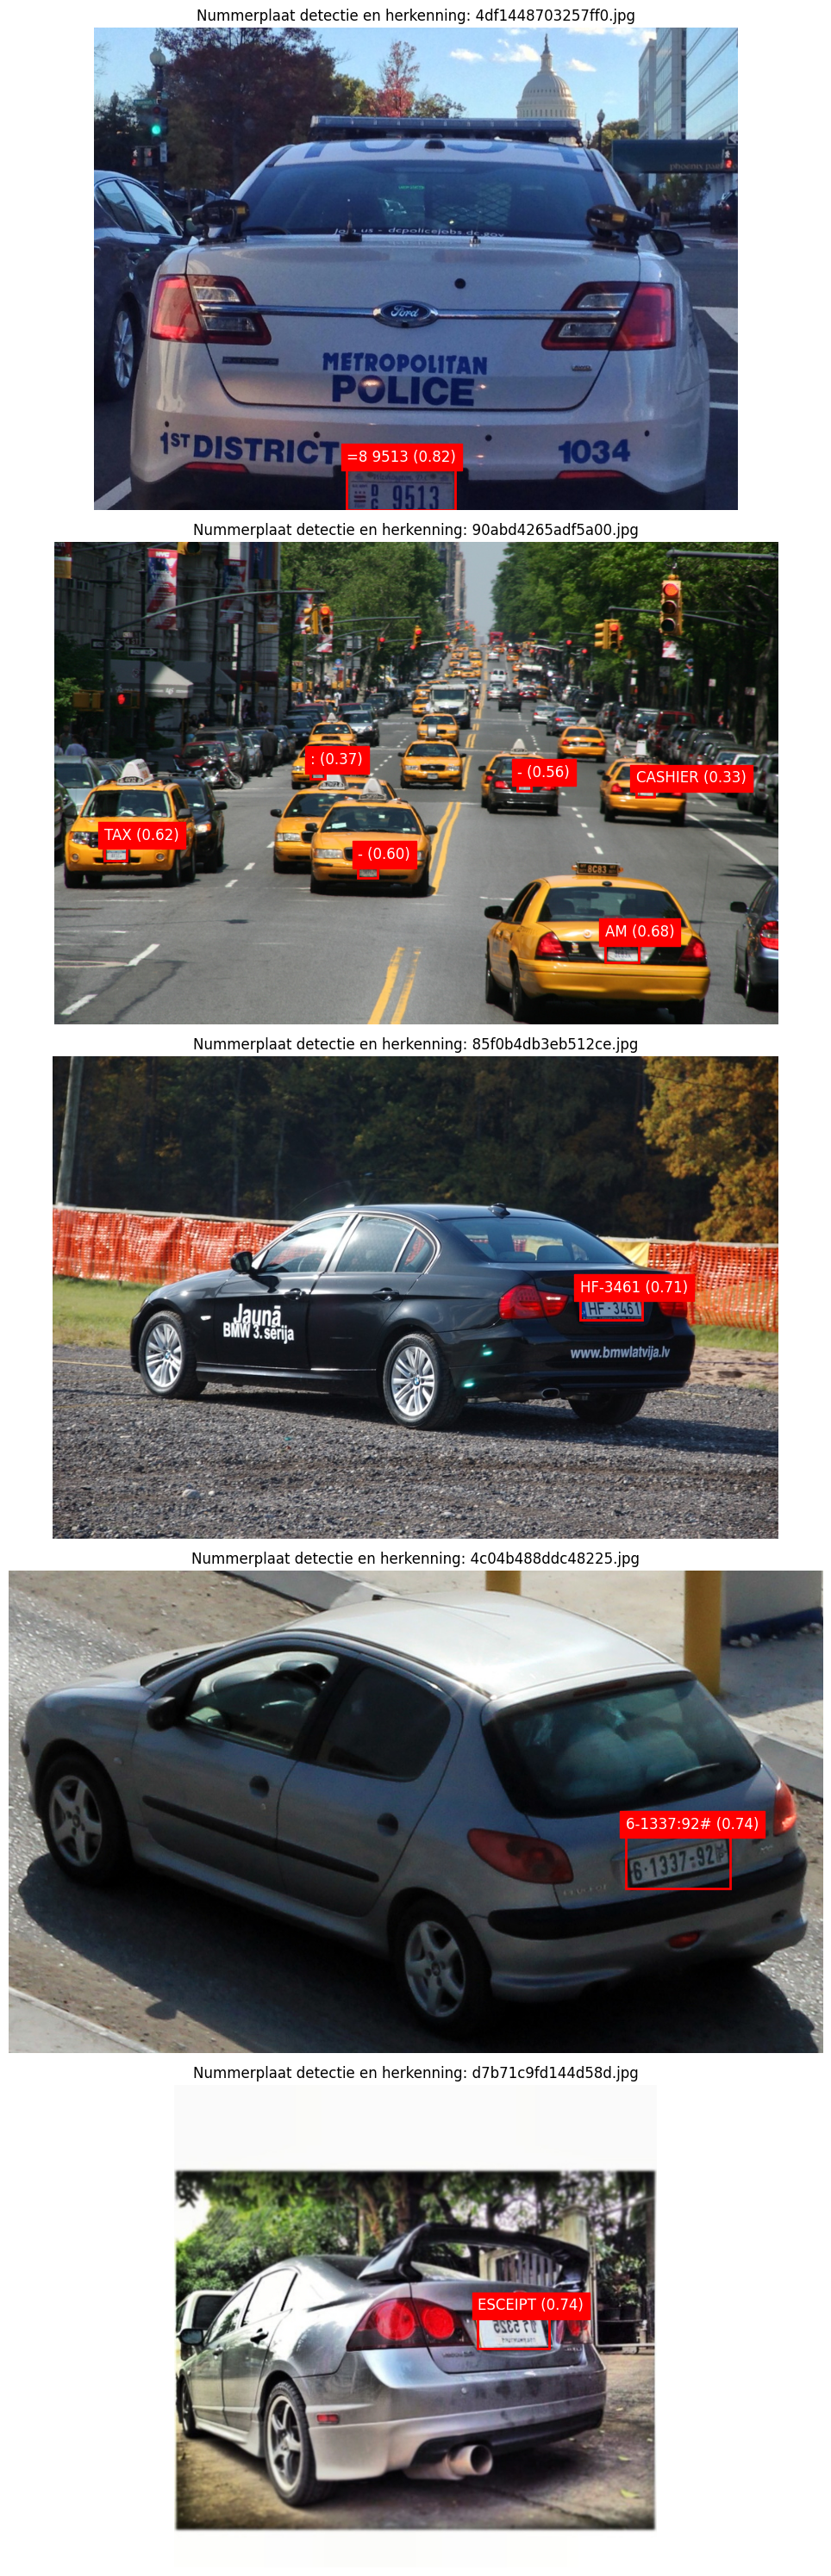


Afbeelding: 4df1448703257ff0.jpg
Gevonden nummerplaten: 1
  Nummerplaat 1: =8 9513 (Betrouwbaarheid: 0.82)

Afbeelding: 90abd4265adf5a00.jpg
Gevonden nummerplaten: 6
  Nummerplaat 1: AM (Betrouwbaarheid: 0.68)
  Nummerplaat 2: TAX (Betrouwbaarheid: 0.62)
  Nummerplaat 3: - (Betrouwbaarheid: 0.60)
  Nummerplaat 4: - (Betrouwbaarheid: 0.56)
  Nummerplaat 5: : (Betrouwbaarheid: 0.37)
  Nummerplaat 6: CASHIER (Betrouwbaarheid: 0.33)

Afbeelding: 85f0b4db3eb512ce.jpg
Gevonden nummerplaten: 1
  Nummerplaat 1: HF-3461 (Betrouwbaarheid: 0.71)

Afbeelding: 4c04b488ddc48225.jpg
Gevonden nummerplaten: 1
  Nummerplaat 1: 6-1337:92# (Betrouwbaarheid: 0.74)

Afbeelding: d7b71c9fd144d58d.jpg
Gevonden nummerplaten: 1
  Nummerplaat 1: ESCEIPT (Betrouwbaarheid: 0.74)


In [7]:
# Gebruik de reeds bestaande test_dir variabele
test_dir = '../../datasets/license_plate_dataset/images/test'
print(f"Test directory: {test_dir}")

# Get a list of all image files in the test directory
image_files = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]
print(f"Found {len(image_files)} image files in test directory")

# Now you can sample from the list
selected_images = random.sample(image_files, min(10, len(image_files)))

# Gebruik de reeds geselecteerde afbeeldingen of selecteer willekeurig 10 afbeeldingen als dit nog niet is gedaan
if 'selected_images' not in locals():
    selected_images = random.sample(image_files, 10)
    
# Selecteer 5 afbeeldingen voor verwerking
display_count = 5
images_to_process = selected_images[:display_count]

# Maak een figuur met subplots voor alle afbeeldingen
fig, axes = plt.subplots(display_count, 1, figsize=(15, 6*display_count))

# Als er maar één afbeelding is, zorg dan dat axes een lijst is
if display_count == 1:
    axes = [axes]

# Verwerk elke afbeelding en toon resultaten
all_results = []

for idx, image_file in enumerate(images_to_process):
    image_path = os.path.join(test_dir, image_file)
    
    # Verwerk de afbeelding
    results = process_image(image_path)
    all_results.append({"file": image_file, "results": results})
    
    # Toon de afbeelding met gedetecteerde nummerplaten
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    axes[idx].imshow(image_rgb)
    
    # Teken bounding boxes en tekst op de afbeelding
    for result in results:
        x1, y1, x2, y2 = result['bbox']
        confidence = result['confidence']
        text = result['text']
        
        # Teken bounding box
        axes[idx].add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, 
                                     fill=False, edgecolor='red', linewidth=2))
        
        # Toon tekst boven de bounding box
        axes[idx].text(x1, y1-10, f"{text} ({confidence:.2f})", 
                   color='white', backgroundcolor='red', fontsize=12)
    
    axes[idx].set_title(f"Nummerplaat detectie en herkenning: {image_file}")
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Toon tekstuele resultaten voor alle afbeeldingen
for img_result in all_results:
    image_file = img_result["file"]
    results = img_result["results"]
    print(f"\nAfbeelding: {image_file}")
    print(f"Gevonden nummerplaten: {len(results)}")
    for i, result in enumerate(results):
        print(f"  Nummerplaat {i+1}: {result['text']} (Betrouwbaarheid: {result['confidence']:.2f})")